#PSG-Audio_load_dataset.ipynb
This is the loader for the open access PSG-Audio Polysomnography (it was originally PSG-Audio_load_dataset_10_90_split.ipynb in our internal repo).

No data is stored in this repository. If you use the dataset please follow the original author's citation requests.

Paper: https://www.nature.com/articles/s41597-021-00977-w

Download: https://www.scidb.cn/en/detail?dataSetId=778740145531650048

This dataset is very large, for that reason the download is bit more complex and the high sample rate audio channels are not included.

The associated Jupyter notebook PSG-Audio_download_dataset.ipynb downloads and processes the files associated with a single subject into a pickled IR1 Pandas dataframe for each recorded overnight session.

The psg_audio_12ch_50sub_ir1_ptX.zip files contain the pickled dataframes for the first 50 subjects and is the input for this notebook.   

If you want to load additional subjects, change the sample frequency, or include other channels (body position, pulse rate, or the two audio) the dataframes must be downloaded and processed again (this takes about 25 minutes per subject).  

Altering the window size or step, selecting a subset of the channels, or changing subject allocation between train/valid/test can be done using stored pickled dataframes and this notebook.

This is work in progress and frequently updated, please check the repository at our [IMICS Lab Github repository](https://github.com/imics-lab/load_data_time_series) for the latest.

The basic load_data flow is modified a bit for this large dataset.
* Download and process the .rml and .edf datafiles associated with each subject in batches using PSA-Audio_download_dataset.ipynb.  This is performed by PSG-Audio_download_dataset.ipynb.  The download takes long time, approximately 25 minutes per subject.
* Unzip and read the pickled IR1 dataframes by subject
* Convert into IR2 - a set of two numpy arrays containing sliding window samples
   * X = (samples, time steps per sample, channels)  
   * y =  (samples, labels) # activity classification
   * sub = (samples, subject_number)
* Further process the IR2 arrays as needed - this is train/test aware, e.g. the training set may be better balanced by drop some majority class labels whereas the IR2s from subjects in the test set will not be.
* Concatenate the individual IR2 arrays into train/valid/test IR3 arrays 

Unlike some of the more simple loaders which can run as stand-alone .py files this notebook is currently setup to be run interactively with the resulting numpy arrays saved at the end.

<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.

[Lee B. Hinkle](https://userweb.cs.txstate.edu/~lbh31/), Texas State University, [IMICS Lab](https://imics.wp.txstate.edu/)  
TODO:
* Many of the transforms here were developed while building versions for the other datasets; they need to be moved into a common set of functions for all.
* The balancing train and valid needs to be further refined.   Right now the abnormal vs not abnormal (apena and hypopnea) roughly match but that means the two abnormal and cardiac classes are still very unbalanced.


In [1]:
import os
import shutil #https://docs.python.org/3/library/shutil.html
from shutil import unpack_archive # to unzip
#from shutil import make_archive # to create zip for storage
#import requests #for downloading zip file
#from scipy import io #for loadmat, matlab conversion
import time
import csv # probably not needed once download processes zip
import pandas as pd
import numpy as np
from numpy import savetxt
from tabulate import tabulate # for verbose tables, showing data
from tensorflow.keras.utils import to_categorical # for one-hot encoding
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt # for plotting - pandas uses matplotlib
from time import gmtime, strftime, localtime #for displaying Linux UTC timestamps in hh:mm:ss
from datetime import datetime, date, timedelta
import urllib.request # to get files from web w/o !wget

# Get Load Data Utility functions
Tablulate is used to reduce lines of code.


In [2]:
my_dir = '.' # replace with absolute path if desired
working_dir = os.path.join(my_dir,'psg_temp') # created scratch directory
if not os.path.exists(working_dir):
    os.mkdir(working_dir)
interactive = True # for exploring data and functions interactively
verbose = True
# setup a global readme so various methods can append info as needed
readme = 'This readme auto-generated by PSG-Audio_load_dateset_10_90.ipynb\n'
readme += 'Executed on '
today = date.today()
readme += today.strftime("%B %d, %Y") + "\n"
readme += 'ref: https://github.com/imics-lab/load_data_time_series \n'

In [3]:
def get_load_data_utils():
    """checks for local file, if none downloads from IMICS repository.
    Assumes a global my_dir has been defined (default is my_dir = ".")
    :return: nothing"""
    fname = 'load_data_utils.py'
    ffname = os.path.join(my_dir,fname)
    if (os.path.exists(ffname)):
        if verbose:
            print ("Local load_data_utils.py found, skipping download")
    else:
        print("Downloading",fname, "from IMICS git repo")
        urllib.request.urlretrieve("https://raw.githubusercontent.com/imics-lab/load_data_time_series/main/load_data_utils.py", filename=fname)

get_load_data_utils()

In [4]:
from load_data_utils import get_env_info
from load_data_utils import get_log_ffname
from load_data_utils import tabulate_numpy_arrays
if interactive:
    print('My env_info: \n' + get_env_info()) # using + vs , gets rid of space

My env_info: 
model name	: AMD EPYC 7B12
model name	: AMD EPYC 7B12
model name	: AMD EPYC 7B12
model name	: AMD EPYC 7B12
GPU: NVIDIA-SMI failed, no GPU found


In [5]:
# Note it is much faster to zip before copying to colab, but in this case
# I don't think this will be rerun often and it is a pain to deal with the
# very large zipfiles that have a lot of subjects.
dataset_dir_list = ['/content/drive/MyDrive/Datasets/PSG_audio_12ch_50sub_IR1',
                    '/content/drive/MyDrive/Datasets/PSG_audio_12ch_50plus_IR1']

In [7]:
# this moves all the pkl files into colab, takes a few minutes to run
import glob
all_sub_list = []
for ds_dir in dataset_dir_list:
    for file in glob.glob(ds_dir+r'/*.pkl'):  # the r is a string escape
        print(file)
        # this next goofy mess extracts the sub number
        all_sub_list.append(file.split('/')[-1].split('_')[0])
        shutil.copy(file, working_dir)
all_sub_list = [int(i) for i in all_sub_list] # convert str to int

/content/drive/MyDrive/Datasets/PSG_audio_12ch_50sub_IR1/995_ir1_df.pkl
/content/drive/MyDrive/Datasets/PSG_audio_12ch_50sub_IR1/999_ir1_df.pkl
/content/drive/MyDrive/Datasets/PSG_audio_12ch_50sub_IR1/1086_ir1_df.pkl
/content/drive/MyDrive/Datasets/PSG_audio_12ch_50sub_IR1/1000_ir1_df.pkl
/content/drive/MyDrive/Datasets/PSG_audio_12ch_50sub_IR1/1088_ir1_df.pkl
/content/drive/MyDrive/Datasets/PSG_audio_12ch_50sub_IR1/1006_ir1_df.pkl
/content/drive/MyDrive/Datasets/PSG_audio_12ch_50sub_IR1/1089_ir1_df.pkl
/content/drive/MyDrive/Datasets/PSG_audio_12ch_50sub_IR1/1008_ir1_df.pkl
/content/drive/MyDrive/Datasets/PSG_audio_12ch_50sub_IR1/1093_ir1_df.pkl
/content/drive/MyDrive/Datasets/PSG_audio_12ch_50sub_IR1/1010_ir1_df.pkl
/content/drive/MyDrive/Datasets/PSG_audio_12ch_50sub_IR1/1095_ir1_df.pkl
/content/drive/MyDrive/Datasets/PSG_audio_12ch_50sub_IR1/1014_ir1_df.pkl
/content/drive/MyDrive/Datasets/PSG_audio_12ch_50sub_IR1/1097_ir1_df.pkl
/content/drive/MyDrive/Datasets/PSG_audio_12ch_50sub_

In [8]:
# Sanity check - there should be 192 files as there are 192 subjects in processed IR1s
count = 0
# Iterate directory
for path in os.listdir(working_dir):
    # check if current path is a file
    if os.path.isfile(os.path.join(working_dir, path)):
        count += 1
print('File count:', count)
print('Length of all_sub_list:',len(all_sub_list))

File count: 192
Length of all_sub_list: 192


# Split all subjects with 10% going to "labeled" set and remander to "unlabeled"

In [9]:
labeled_subs_list = all_sub_list[::10]
# credit Donut https://stackoverflow.com/questions/4211209/remove-all-the-elements-that-occur-in-one-list-from-another
# this removes the labeled subs from the full list to leave the unlabeled ones
unlabeled_subs_list = [x for x in all_sub_list if x not in labeled_subs_list]
print(labeled_subs_list)
print(len(labeled_subs_list),"labeled subs")
print(unlabeled_subs_list)
print(len(unlabeled_subs_list),"unlabeled subs")

[995, 1095, 1112, 1126, 1137, 1155, 1206, 1198, 1249, 1151, 1228, 1252, 1274, 1335, 1365, 1384, 1406, 1436, 1457, 1492]
20 labeled subs
[999, 1086, 1000, 1088, 1006, 1089, 1008, 1093, 1010, 1014, 1097, 1016, 1106, 1018, 1108, 1020, 1110, 1022, 1024, 1116, 1026, 1118, 1037, 1039, 1120, 1122, 1041, 1043, 1045, 1127, 1057, 1129, 1059, 1131, 1135, 1069, 1071, 1073, 1082, 1084, 1139, 1145, 1028, 1104, 1143, 1157, 1147, 1163, 1169, 1171, 1172, 1174, 1204, 1178, 1182, 1208, 1186, 1191, 1210, 1193, 1215, 1197, 1217, 1219, 1200, 1222, 1202, 1224, 1226, 1232, 1241, 1247, 1250, 1256, 1262, 1263, 1270, 1276, 1282, 1284, 1285, 1287, 1153, 1288, 1161, 1290, 1176, 1292, 1195, 1294, 1295, 1230, 1299, 1234, 1239, 1301, 1303, 1245, 1305, 1306, 1254, 1308, 1258, 1310, 1265, 1312, 1268, 1314, 1316, 1318, 1320, 1322, 1324, 1327, 1329, 1331, 1333, 1337, 1340, 1342, 1344, 1355, 1357, 1358, 1360, 1361, 1367, 1369, 1371, 1373, 1374, 1376, 1378, 1380, 1382, 1386, 1388, 1390, 1392, 1394, 1396, 1398, 1400, 1402, 

In [10]:
# three to test, one to valid, test, repeat.
labeled_subs_np = np.array(labeled_subs_list)
temp_subs = labeled_subs_np.reshape(-1,5) # make 2D with 5 colums for 3,1,1 allocate
print(temp_subs)
train_subs = temp_subs[:,:3].reshape(-1) # first 3 columns then flatten
valid_subs = temp_subs[:,3].reshape(-1) # numpy is trippy sometime, just col 3
test_subs = temp_subs[:,4].reshape(-1)
labeled_subs_split_dict = dict(train_subj = train_subs.tolist(),
                valid_subj = valid_subs.tolist(),
                test_subj = test_subs.tolist())
print(labeled_subs_split_dict)

# processing the full list of unlabeled subs crashes by using up all memory
# in colab high-RAM runtime.   Cutting in half to keep moving forward.
unlabeled_subs_list =  unlabeled_subs_list[::2]
print("New length of unlabeled_subs_list", len(unlabeled_subs_list))

# unlabeled subs not divisible by 5 so just putting all in train
unlabeled_subs_split_dict = dict(train_subj = unlabeled_subs_list,
                valid_subj = [],
                test_subj = [])
print(unlabeled_subs_split_dict)

[[ 995 1095 1112 1126 1137]
 [1155 1206 1198 1249 1151]
 [1228 1252 1274 1335 1365]
 [1384 1406 1436 1457 1492]]
{'train_subj': [995, 1095, 1112, 1155, 1206, 1198, 1228, 1252, 1274, 1384, 1406, 1436], 'valid_subj': [1126, 1249, 1335, 1457], 'test_subj': [1137, 1151, 1365, 1492]}
New length of unlabeled_subs_list 86
{'train_subj': [999, 1000, 1006, 1008, 1010, 1097, 1106, 1108, 1110, 1024, 1026, 1037, 1120, 1041, 1045, 1057, 1059, 1135, 1071, 1082, 1139, 1028, 1143, 1147, 1169, 1172, 1204, 1182, 1186, 1210, 1215, 1217, 1200, 1202, 1226, 1241, 1250, 1262, 1270, 1282, 1285, 1153, 1161, 1176, 1195, 1295, 1299, 1239, 1303, 1305, 1254, 1258, 1265, 1268, 1316, 1320, 1324, 1329, 1333, 1340, 1344, 1357, 1360, 1367, 1371, 1374, 1378, 1382, 1388, 1392, 1396, 1400, 1408, 1412, 1419, 1428, 1432, 1440, 1444, 1449, 1453, 1459, 1463, 1476, 1480, 1488], 'valid_subj': [], 'test_subj': []}


In [ ]:
interactive = False

Dataframe shape is (1554400, 17)


,EEG A1-A2,EEG C3-A2,EEG C4-A1,EOG LOC-A2,EOG ROC-A2,EMG Chin,Leg 1,Leg 2,ECG I,Flow Patient,Effort THO,Effort ABD,Cardiac,Respiratory,SpO2,Neuro,sub
calc_time,,,,,,,,,,,,,,,,,
2019-07-30 08:45:10.000,0.004776,0.004776,0.004776,0.004776,0.004776,0.00119,0.00119,0.00119,0.127153,0.001526,0.001526,0.001526,0,0,0,0,1126
2019-07-30 08:45:10.010,0.004776,0.004776,0.004776,0.004776,0.004776,0.00119,0.00119,0.00119,0.127153,0.001526,0.001526,0.001526,0,0,0,0,1126
2019-07-30 08:45:10.020,0.004776,0.004776,0.004776,0.004776,0.004776,0.00119,0.00119,0.00119,0.127153,0.001526,0.001526,0.001526,0,0,0,0,1126
2019-07-30 08:45:10.030,0.004776,0.004776,0.004776,0.004776,0.004776,0.00119,0.00119,0.00119,0.127153,0.001526,0.001526,0.001526,0,0,0,0,1126
2019-07-30 08:45:10.040,0.004776,0.004776,0.004776,0.004776,0.004776,0.00119,0.00119,0.00119,0.127153,0.001526,0.001526,0.001526,0,0,0,0,1126


,EEG A1-A2,EEG C3-A2,EEG C4-A1,EOG LOC-A2,EOG ROC-A2,EMG Chin,Leg 1,Leg 2,ECG I,Flow Patient,Effort THO,Effort ABD,Cardiac,Respiratory,SpO2,Neuro,sub
calc_time,,,,,,,,,,,,,,,,,
2019-07-30 13:04:13.950,182.947510,83.452339,88.801544,142.752075,9.480507,17.673334,-78.000000,78.0,-67.264168,-3.498894,-11.250477,20.061035,0,0,0,0,1126
2019-07-30 13:04:13.960,126.245956,48.300434,132.206497,99.805618,4.742641,-14.928725,26.052368,-78.0,16.911406,-3.489738,-11.973755,20.152590,0,0,0,0,1126
2019-07-30 13:04:13.970,279.538818,208.929352,132.665009,259.059021,60.068680,65.357658,-78.000000,78.0,1.907301,-3.483635,-12.660411,20.244144,0,0,0,0,1126
2019-07-30 13:04:13.980,165.982895,84.216507,143.516251,130.066818,17.733562,-9.748959,-8.225498,78.0,21.488930,-3.486686,-13.328755,20.143435,0,0,0,0,1126
2019-07-30 13:04:13.990,79.172974,6.118151,166.441391,67.099060,-8.706782,-78.000000,78.000000,-78.0,-122.194443,-3.492790,-13.933013,19.813841,0,0,0,0,1126


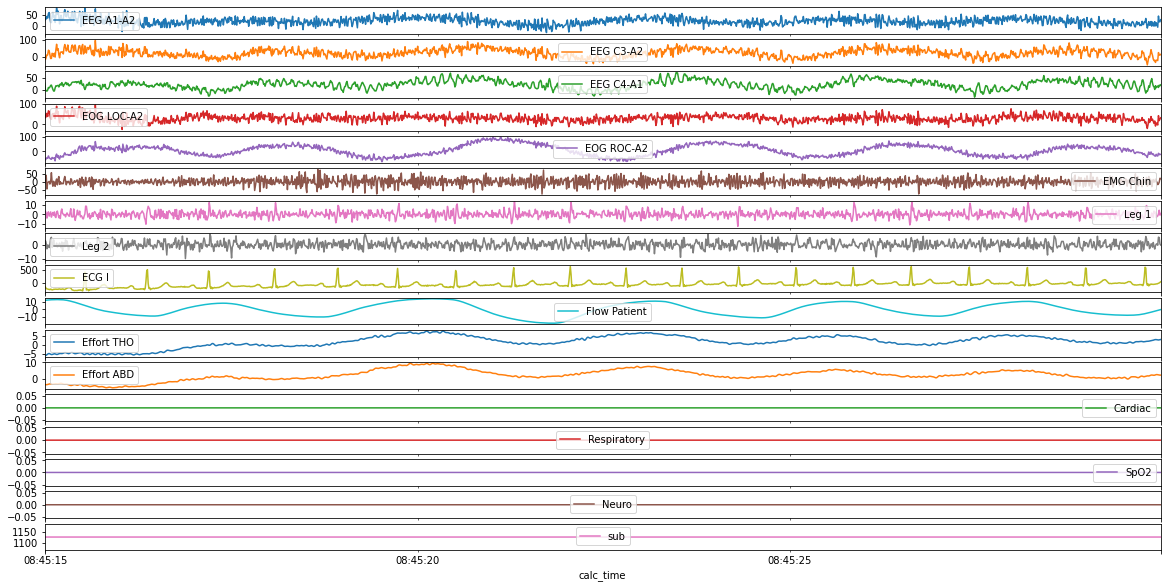

In [11]:
def get_df_from_pkl(sub_num):
    pkl_ffname = os.path.join(working_dir,str(sub_num)+'_ir1_df.pkl')
    df = pd.read_pickle(pkl_ffname)
    return df
if interactive:
    sub_num = 1126 # first subject
    ir1_df = get_df_from_pkl(sub_num = sub_num)
    print("Dataframe shape is",ir1_df.shape)
    display(ir1_df.head())
    display(ir1_df.tail())
    y1 = 1000 # starting y value (row #)
    y2 = 2000 # ending, plotting the whole dataframe is too much.
    #ir1_df.iloc[499:999].plot(y='EEG A1-A2',subplots=True, layout=(1,2))
    ir1_df.iloc[499:1999].plot(subplots=True, figsize=(20, 10)) # yay Pandas

In [12]:
def ir1_labels_to_binary(df, col_label_list):
    """Converts the label columns from 0,1,2,3,etc to 0 (assumed to be normal),
    and 1 (all non-zero rows will be converted to this).  Original usage was
    the PSG-Audio dataset which has multiple labels for abnormal respiratory
    and cardiac events.  Note a PSG-Audio single subject dataframe may not have
    multiple event types and in some cases/catergories are all 'normal'
    args:
        df: an IR1 dataframe (rows = timesteps, cols = channels and labels)
        col_label_list: a list of the column names to be converted.
    returns: an updated IR1 dataframe"""
    for col_label in col_label_list:
        if verbose:
            print(col_label,"event type counts before\n"+str(df[col_label].value_counts(dropna=False)))
        df.loc[df[col_label] > 0, [col_label]] = 1
        if verbose:
            print(col_label,"event type counts after\n"+str(df[col_label].value_counts(dropna=False)))
    return df
if interactive:
    my_df = ir1_labels_to_binary(df = ir1_df, col_label_list = ['Respiratory'])
    #can run this plot before and after to sanity check, indices vary by sub
    #ir1_df['Respiratory'].iloc[300000:400000].plot(figsize=(20, 10))

Respiratory event type counts before
0    1171700
1     215600
4     135500
3      22500
2       9100
Name: Respiratory, dtype: int64
Respiratory event type counts after
0    1171700
1     382700
Name: Respiratory, dtype: int64


In [13]:
def get_ir2_from_ir1(df, all_label_list, keep_label, 
                     time_steps, stride, sub_label = 'sub'):
    """This is a PSG-Audio specific method for now.  Has the four event family
    label channels hardcoded but only preserves Respiratory labels.
    Original description: slice the IR1 dataframe into sliding window segments
    of time_steps length and return X, y, sub ndarrays.
    If stride = time_steps there is no overlap of the sliding window.
    This version does not use append, better for RAM
        df: pandas datetime indexed dataframe columns - channel(s), label(s), sub
        all_label_list: column names of label columns, will be removed for X
        keep_label: the column name of the label to be placed in y
        time_steps: number of samples in window, drops a partial final window
        stride:  how far to move window, no overlap if equal to time_steps.
        sub_label: the column name of the subject column, default is 'sub'
    """    
    # the channel list is pulled from dataframe it is not in the numpy arrays
    # so it is returned by the function along with the numpy arrays.
    # TODO: add a check for labels and sub column matches.
    channel_list = list(df.columns)
    for item in all_label_list:
        channel_list.remove(item)
    channel_list.remove(sub_label)
    if verbose:
        print('Channels in X:',channel_list)
    X = df[channel_list].to_numpy(dtype = 'float32')
    y = df[keep_label].to_numpy(dtype='int8') # this drops other labels
    sub = df[sub_label].to_numpy(dtype = 'int16') # for more than 255 subs
    if verbose:
        print('X,y,sub array shapes before sliding window', X.shape, y.shape, sub.shape)
    #https://numpy.org/devdocs/reference/generated/numpy.lib.stride_tricks.sliding_window_view.html
    shapex = (time_steps,X.shape[1]) # samples (rows to include) and n-dim of original (all channels)
    shapey = (time_steps,) # samples (rows to include) and only one column
    shapesub = (time_steps,) # samples (rows to include) and only one column
    X = np.lib.stride_tricks.sliding_window_view(X, shapex)[::stride, :]
    X = X[:,0,:,:] # I admit I don't understand why this dimension appears...
    y = np.lib.stride_tricks.sliding_window_view(y, shapey)[::stride, :]
    #y = y[:,0,:,:] # I admit I don't understand why this dimension appears...
    sub = np.lib.stride_tricks.sliding_window_view(sub, shapesub)[::stride, :]
    if verbose:
        print('time_steps =', time_steps, 'stride = ',stride)
        print('X,y,sub array shapes after sliding window', X.shape, y.shape, sub.shape)
    return X, y, sub, channel_list
if interactive:
    my_X, my_y, my_sub, my_channel_list = \
    get_ir2_from_ir1(ir1_df, all_label_list = ['Cardiac', 'Respiratory', 'SpO2', 'Neuro'],
                     keep_label = 'Respiratory', time_steps = 500, stride = 500)
    print("IR2 array info for sub number",np.unique(my_sub))
    print("Returned my_channel_list", my_channel_list)
    print(tabulate_numpy_arrays({"my_X":my_X, "my_y":my_y, "my_sub":my_sub}))

Channels in X: ['EEG A1-A2', 'EEG C3-A2', 'EEG C4-A1', 'EOG LOC-A2', 'EOG ROC-A2', 'EMG Chin', 'Leg 1', 'Leg 2', 'ECG I', 'Flow Patient', 'Effort THO', 'Effort ABD']
X,y,sub array shapes before sliding window (1554400, 12) (1554400,) (1554400,)
time_steps = 500 stride =  500
X,y,sub array shapes after sliding window (3108, 500, 12) (3108, 500) (3108, 500)
IR2 array info for sub number [1126]
Returned my_channel_list ['EEG A1-A2', 'EEG C3-A2', 'EEG C4-A1', 'EOG LOC-A2', 'EOG ROC-A2', 'EMG Chin', 'Leg 1', 'Leg 2', 'ECG I', 'Flow Patient', 'Effort THO', 'Effort ABD']
array    shape            data type
-------  ---------------  -----------
my_X     (3108, 500, 12)  float32
my_y     (3108, 500)      int8
my_sub   (3108, 500)      int16


In [14]:
def clean_ir2(X, y, sub):
    """removes sliding windows containing NaN, multiple labels, or multiple
    subject numbers.  Collapses y, sub to column arrays.
    Returns cleaned versions of X, y, sub ndarrays"""
    # Copied directly from SHL.  Yay!
    # Check for NaN
    nans = np.argwhere(np.isnan(X))
    num_nans = np.unique(nans[:,0]) #[:,0] just 1st column index of rows w/ NaN
    if verbose:
        print(num_nans.shape[0], "NaN entries found, removing")
    idx = ~np.isnan(X).any(axis=2).any(axis=1)
    # this warrants some explanation!
    # any(axis=1) and 2 collapses channels and samples
    # good axis explanation https://www.sharpsightlabs.com/blog/numpy-axes-explained/
    # the ~ negates so NaN location are now False in the idx which is then
    # used to filter out the bad windows below
    X = X[idx]
    y = y[idx]
    sub = sub[idx]
    # repeat and confirm NaNs have been removed
    nans = np.argwhere(np.isnan(X))
    num_nans = np.unique(nans[:,0]) #[:,0] accesses just 1st column
    if (nans.size!=0):
        print("WARNING! Cleaned output arrays still contain NaN entries")
        print("execute print(X[99]) # to view single sample")
    # Now get rid of segments with multiple labels
    # Not happy with this code, must be a better way but it seems to work...
    idx = []
    for i in range(y.shape[0]):
        if np.all(y[i] == y[i][0]):
            idx.append(True)
        else:
            idx.append(False)
            #print('Discarding Row:', i)
    X = X[idx]
    y = y[idx]
    sub = sub[idx]
    # TODO check for multiple subjects in window
    y = y[:,0] # collapse columns
    y = y[np.newaxis].T  # convert to single column array
    sub = sub[:,0] # repeat for sub array
    sub = sub[np.newaxis].T
    return X, y, sub
if interactive:
    my_X, my_y, my_sub = clean_ir2(my_X, my_y, my_sub)
    print('IR2 shapes after cleaning')
    print(tabulate_numpy_arrays({"my_X":my_X, "my_y":my_y, "my_sub":my_sub}))

0 NaN entries found, removing
IR2 shapes after cleaning
array    shape            data type
-------  ---------------  -----------
my_X     (2616, 500, 12)  float32
my_y     (2616, 1)        int8
my_sub   (2616, 1)        int16


# Allocate subject to different arrays
Note is is very different code from the splits done in the regular load_dataset.

In [ ]:
interactive = False

In [15]:
def get_ir3(er1_sub_list = unlabeled_subs_list,
            time_steps = 500,
            stride = 500 #if equal to time_steps there will be no overlap of sliding window
    ):
    """This is the main function to create the three ndarrays X, y, sub from
    the dataset zip file.  It is an updated version of get_xys.  
    2) Read and processes each subject's PSG IR1 dataframe into X (data),
     y (labels), and sub (subject number) IR2 ndarrays.
    3) Stackes the IR2 arrays into IR3 (X, y, sub) arrays
    """
    # create blank ndarrays to append to
    num_ch = 12 # the number of signal channels is the 3rd dim of X
    ir3_X = np.zeros(shape=(1,time_steps,num_ch), dtype = 'float32')
    ir3_y = np.zeros(shape=(1,1),dtype='int8') # only a few labels
    ir3_sub = np.zeros(shape=(1,1),dtype='int16') # PSG-Audio has > 255 sub #s
    print("er1_sub_list", er1_sub_list)
    for sub_num in er1_sub_list:
        #if verbose:
        #print('Processing ', sub_num)
        ir1_df = get_df_from_pkl(sub_num = sub_num)
        #print(ir1_df['sub'].head)
        ir1_df = ir1_labels_to_binary(df = ir1_df, col_label_list = ['Respiratory']) # all abnormal events = 1

        #if verbose:
        #    ir1_df['Cardiac'].value_counts()
        #    print ("Label Counts - # samples before sliding window\n",ir1_df['Cardiac'].value_counts())
        ir2_X, ir2_y, ir2_sub, channel_list = \
            get_ir2_from_ir1(ir1_df, 
                             all_label_list = ['Cardiac', 'Respiratory', 'SpO2', 'Neuro'],
                             keep_label = 'Respiratory', 
                             time_steps = 500, stride = 500)
        #print("First sub entry before vstack" ,ir2_sub[0])
        ir2_X, ir2_y, ir2_sub = clean_ir2(ir2_X, ir2_y, ir2_sub)
        #ir2_X, ir2_y, ir2_sub = drop_label_ir2_ir3(ir2_X, ir2_y, ir2_sub, 'Undefined')
        ir3_X = np.vstack([ir3_X, ir2_X])
        ir3_y = np.vstack([ir3_y, ir2_y])
        #print("First sub entry before vstack" ,ir2_sub[0])
        ir3_sub = np.vstack([ir3_sub, ir2_sub])
        #shutil.rmtree(working_dir)

    #delete first row placeholders
    X = np.delete(ir3_X, (0), axis=0) 
    y = np.delete(ir3_y, (0), axis=0) 
    sub = np.delete(ir3_sub, (0), axis=0)
    sub = sub.astype(np.uint16) # convert from float to int16, more than 255 subs

    xys_info = 'This needs work in PSG-Audio_load_dataset.ipynb\n'
    xys_info += '\nTime steps =' + str(time_steps) + ', Stride =' + str(stride) + ', no resample\n'
    xys_info += 'Final Shapes\n'
    xys_info += "X shape " + str(X.shape) + " dtype = " + str(X.dtype) + "\n"
    xys_info += "y shape " + str(y.shape) + " dtype = " + str(y.dtype) + "\n"
    xys_info += "sub shape " + str(sub.shape) + " dtype = " + str(sub.dtype) + "\n"
    xys_info += "Channel names:" + str(channel_list) + "\n"
    # Get final counts for label ndarray - not quite as easy as pandas df
    xys_info += "Final Label Counts\n"
    unique, counts = np.unique(y, return_counts=True)
    xys_info += str(np.asarray((unique, counts)).T)
    xys_info += "\nSamples per Subject\n"
    unique, counts = np.unique(sub, return_counts=True)
    xys_info += str(np.asarray((unique, counts)).T)
    return X, y, sub, xys_info
if interactive:
    X, y, sub, xys_info = get_ir3()
    print(tabulate_numpy_arrays({"X":X, "y":y, "sub":sub}))
    unique, counts = np.unique(y, return_counts=True)
    print('Label Counts:\n',str(np.asarray((unique, counts)).T))
    print("Sanity check on sub numbers",np.unique(sub))

er1_sub_list [999, 1000, 1006, 1008, 1010, 1097, 1106, 1108, 1110, 1024, 1026, 1037, 1120, 1041, 1045, 1057, 1059, 1135, 1071, 1082, 1139, 1028, 1143, 1147, 1169, 1172, 1204, 1182, 1186, 1210, 1215, 1217, 1200, 1202, 1226, 1241, 1250, 1262, 1270, 1282, 1285, 1153, 1161, 1176, 1195, 1295, 1299, 1239, 1303, 1305, 1254, 1258, 1265, 1268, 1316, 1320, 1324, 1329, 1333, 1340, 1344, 1357, 1360, 1367, 1371, 1374, 1378, 1382, 1388, 1392, 1396, 1400, 1408, 1412, 1419, 1428, 1432, 1440, 1444, 1449, 1453, 1459, 1463, 1476, 1480, 1488]
Respiratory event type counts before
0    1167700
1     195300
4      79800
3      30900
2      16400
Name: Respiratory, dtype: int64
Respiratory event type counts after
0    1167700
1     322400
Name: Respiratory, dtype: int64
Channels in X: ['EEG A1-A2', 'EEG C3-A2', 'EEG C4-A1', 'EOG LOC-A2', 'EOG ROC-A2', 'EMG Chin', 'Leg 1', 'Leg 2', 'ECG I', 'Flow Patient', 'Effort THO', 'Effort ABD']
X,y,sub array shapes before sliding window (1490100, 12) (1490100,) (1490100,

In [16]:
def psg_audio_load_dataset(
    verbose = False,
    use_saved_xysub = False, # get X,y,sub from zip, True = faster to used saved ones
    incl_val_group = False, # split train into train and validate
    split_subj = unlabeled_subs_split_dict,
    #keep_channel_list = ['accel_ttl'],
    one_hot_encode = True, # make y into multi-column one-hot, one for each activity
    return_info_dict = False, # return dict of meta info along with ndarrays
    suppress_warn = False # special case for stratified warning
    ):
    """Requires a zip file of sub IR1 dataframes from PSG-Audio_download.ipynb
    returns arrays by separating into _train, _validate, and _test arrays for
    X and y based on split_sub dictionary."""
    log_info = "Generated by PSG-Audio_load_dataset_10_90.ipynb\n"
    today = date.today()
    log_info += today.strftime("%B %d, %Y") + "\n"
    log_info += "sub dict = " + str(split_subj) + "\n"
    if (not use_saved_xysub):
        X, y, sub, xys_info = get_ir3()
    else:
        # read previously stored X, y, sub arrays instead of creating from zip
        # saves time when running multiple train/test split experiments
        # e.g. passing different subject dictionaries to this method
        # create & save X, y, sub using Leotta_2021_get_X_y_sub.ipynb interactively
        # this is not a big deal for TWristAR which is purposely small.
        input_dir = '/content/drive/MyDrive/Processed_Datasets/PSG_Audio'
        X = np.load(input_dir + '/'+'X.npy')
        y = np.load(input_dir + '/'+'y.npy')
        sub = np.load(input_dir + '/'+'sub.npy')
        log_info += "X, y, sub loaded from "+str(input_dir)+"\n"
    # Drop unwanted channels from X
    #log_info += "Keeping channels" + str(keep_channel_list) + "\n"
    #X = limit_channel_ir3(X, keep_channel_list = keep_channel_list)
    # write initial array info to log_info
    headers = ("Initial Array","shape", "object type", "data type")
    mydata = [("X", X.shape, type(X), X.dtype),
              ("y", y.shape, type(y), y.dtype),
              ("sub", sub.shape, type(sub), sub.dtype)]
    if (verbose):
        print(tabulate(mydata, headers=headers))
    log_info += tabulate(mydata, headers=headers) + "\n"
    
    #One-Hot-Encode y...there must be a better way when starting with strings
    #https://machinelearningmastery.com/how-to-one-hot-encode-sequence-data-in-python/
    # Need to look at https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html

    if (one_hot_encode):
        # integer encode
        y_vector = np.ravel(y) #encoder won't take column vector
        le = LabelEncoder()
        integer_encoded = le.fit_transform(y_vector) #convert from string to int
        name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
        if (verbose):
            print("One-hot-encoding: category names -> int -> one-hot \n")
            print(name_mapping) # seems risky as interim step before one-hot
        log_info += "One Hot:" + str(name_mapping) +"\n\n"
        onehot_encoder = OneHotEncoder(sparse=False)
        integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
        onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
        y=onehot_encoded.astype('uint8')
        #return X,y
    # split by subject number pass in dictionary
    sub_num = np.ravel(sub[ : , 0] ) # convert shape to (1047,)
    if (not incl_val_group):
        train_index = np.nonzero(np.isin(sub_num, split_subj['train_subj'] + 
                                        split_subj['valid_subj']))
        x_train = X[train_index]
        y_train = y[train_index]
    else:
        train_index = np.nonzero(np.isin(sub_num, split_subj['train_subj']))
        x_train = X[train_index]
        y_train = y[train_index]

        validation_index = np.nonzero(np.isin(sub_num, split_subj['valid_subj']))
        x_validation = X[validation_index]
        y_validation = y[validation_index]

    test_index = np.nonzero(np.isin(sub_num, split_subj['test_subj']))
    x_test = X[test_index]
    y_test = y[test_index]

    headers = ("Returned Array","shape", "object type", "data type")
    mydata = [("x_train:", x_train.shape, type(x_train), x_train.dtype),
                    ("y_train:", y_train.shape ,type(y_train), y_train.dtype)]
    if (incl_val_group):
        mydata += [("x_validation:", x_validation.shape, type(x_validation), x_validation.dtype),
                        ("y_validation:", y_validation.shape ,type(y_validation), y_validation.dtype)]
    mydata += [("x_test:", x_test.shape, type(x_test), x_test.dtype),
                    ("y_test:", y_test.shape ,type(y_test), y_test.dtype)]
    if (verbose):
        print(tabulate(mydata, headers=headers))
    log_info += tabulate(mydata, headers=headers)
    if (incl_val_group):
        if (return_info_dict):
            return x_train, y_train, x_validation, y_validation, x_test, y_test, log_info
        else:
            return x_train, y_train, x_validation, y_validation, x_test, y_test
    else:
        if (return_info_dict):
            return x_train, y_train, x_test, y_test, log_info
        else:
            return x_train, y_train, x_test, y_test


# Main is setup to be a demo and bit of unit test.

In [17]:
verbose = False # otherwise a lot of output from main.

In [18]:
if __name__ == "__main__":
    print("Get PSG-Audio (50 sub version)")
    x_train, y_train, x_valid, y_valid, x_test, y_test, log_info \
                             = psg_audio_load_dataset(incl_val_group = True,
                                                      return_info_dict = True)
    headers = ("Array","shape", "data type")
    mydata = [("x_train:", x_train.shape, x_train.dtype),
            ("y_train:", y_train.shape, y_train.dtype),
            ("x_valid:", x_valid.shape, x_valid.dtype),
            ("y_valid:", y_valid.shape, y_valid.dtype),
            ("x_test:", x_test.shape, x_test.dtype),
            ("y_test:", y_test.shape, y_test.dtype)]
    print("\n",tabulate(mydata, headers=headers))
    print ('\n','-'*72) # just a dashed line

    print("\n----------- Contents of returned log_info ---------------")
    print(log_info)

Get PSG-Audio (50 sub version)
er1_sub_list [999, 1000, 1006, 1008, 1010, 1097, 1106, 1108, 1110, 1024, 1026, 1037, 1120, 1041, 1045, 1057, 1059, 1135, 1071, 1082, 1139, 1028, 1143, 1147, 1169, 1172, 1204, 1182, 1186, 1210, 1215, 1217, 1200, 1202, 1226, 1241, 1250, 1262, 1270, 1282, 1285, 1153, 1161, 1176, 1195, 1295, 1299, 1239, 1303, 1305, 1254, 1258, 1265, 1268, 1316, 1320, 1324, 1329, 1333, 1340, 1344, 1357, 1360, 1367, 1371, 1374, 1378, 1382, 1388, 1392, 1396, 1400, 1408, 1412, 1419, 1428, 1432, 1440, 1444, 1449, 1453, 1459, 1463, 1476, 1480, 1488]


/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(



 Array     shape              data type
--------  -----------------  -----------
x_train:  (243933, 500, 12)  float32
y_train:  (243933, 2)        uint8
x_valid:  (0, 500, 12)       float32
y_valid:  (0, 2)             uint8
x_test:   (0, 500, 12)       float32
y_test:   (0, 2)             uint8

 ------------------------------------------------------------------------

----------- Contents of returned log_info ---------------
Generated by PSG-Audio_load_dataset_10_90.ipynb
March 16, 2023
sub dict = {'train_subj': [999, 1000, 1006, 1008, 1010, 1097, 1106, 1108, 1110, 1024, 1026, 1037, 1120, 1041, 1045, 1057, 1059, 1135, 1071, 1082, 1139, 1028, 1143, 1147, 1169, 1172, 1204, 1182, 1186, 1210, 1215, 1217, 1200, 1202, 1226, 1241, 1250, 1262, 1270, 1282, 1285, 1153, 1161, 1176, 1195, 1295, 1299, 1239, 1303, 1305, 1254, 1258, 1265, 1268, 1316, 1320, 1324, 1329, 1333, 1340, 1344, 1357, 1360, 1367, 1371, 1374, 1378, 1382, 1388, 1392, 1396, 1400, 1408, 1412, 1419, 1428, 1432, 1440, 1444, 1449,

# Special processing due to highly unbalanced nature of PSG_Audio
This drops approximately 2/3rds of the normal samples from the training set and half the normal samples from the validation set.   Should probably look at the splits first and make a more algorithmic decision.

Note this version is setup for 20s window which is extremely unbalanced - the mod values will need to be changed for any other window size.

This really needs to be put into a function or use existing libraries.  Good write-up here:
https://towardsdatascience.com/how-to-balance-a-dataset-in-python-36dff9d12704


In [19]:
y_train_bin = np.argmax(y_train, axis=-1) # undo one-hot encoding
y_valid_bin = np.argmax(y_valid, axis=-1) # undo one-hot encoding
balancing_info = "Rebalancing by dropping some 'normal' windows, see notes.\n"
balancing_info += "Train counts before:\n"
unique, counts = np.unique(y_train_bin, return_counts=True)
balancing_info += str(np.asarray((unique, counts)).T) + "\n"
balancing_info += "Valid counts before:\n"
unique, counts = np.unique(y_valid_bin, return_counts=True)
balancing_info += str(np.asarray((unique, counts)).T) + "\n"
# This drops any 'normal' window that has a value not evenly
# divisible by 3.  Not exactly 2 in 3 but close for very unbalanced
idx = []
for i in range(y_train_bin.shape[0]):
    if (y_train_bin[i] == 0) and (i%3 == 0):  # set mod based on imbalance
        idx.append(True)
    elif (y_train_bin[i] == 1):
        idx.append(True)
    else:
        idx.append(False)
y_train = y_train[idx]
x_train = x_train[idx]
# repeat for valid set since accuracy metric used for hyper-tuning
idx = []
for i in range(y_valid_bin.shape[0]):
    if (y_valid_bin[i] == 0) and (i%6 == 0):
        idx.append(True)
    elif (y_valid_bin[i] == 1):
        idx.append(True)
    else:
        idx.append(False)
y_valid = y_valid[idx]
x_valid = x_valid[idx]
unique, counts = np.unique(np.argmax(y_train, axis=-1), return_counts=True)
balancing_info += "Train counts after:\n"
balancing_info += str(np.asarray((unique, counts)).T) +"\n"
unique, counts = np.unique(np.argmax(y_valid, axis=-1), return_counts=True)
balancing_info += "Valid counts after:\n"
balancing_info += str(np.asarray((unique, counts)).T) +"\n"
print(balancing_info)

headers = ("Array","shape", "data type")
mydata = [("x_train:", x_train.shape, x_train.dtype),
        ("y_train:", y_train.shape, y_train.dtype),
        ("x_valid:", x_valid.shape, x_valid.dtype),
        ("y_valid:", y_valid.shape, y_valid.dtype),
        ("x_test:", x_test.shape, x_test.dtype),
        ("y_test:", y_test.shape, y_test.dtype)]
print("\n",tabulate(mydata, headers=headers))

Rebalancing by dropping some 'normal' windows, see notes.
Train counts before:
[[     0 182208]
 [     1  61725]]
Valid counts before:
[]
Train counts after:
[[    0 60628]
 [    1 61725]]
Valid counts after:
[]


 Array     shape              data type
--------  -----------------  -----------
x_train:  (122353, 500, 12)  float32
y_train:  (122353, 2)        uint8
x_valid:  (0, 500, 12)       float32
y_valid:  (0, 2)             uint8
x_test:   (0, 500, 12)       float32
y_test:   (0, 2)             uint8


#Save arrays to drive
This is common code and untested - TWristAR is small so download and processing is fast.

For some of the larger datsets it is a big time benefit to store the arrays either before or after train/test split.  

In [ ]:
if True: #change to true to save files interactively
    output_dir = '/content/drive/MyDrive/Processed_Datasets/PSG-Audio/PSG_12ch_unlabeled_86sub'
    if (os.path.isdir(output_dir)):
        #quick check for existing files, '.ipynb_checkpoints' file 
        #makes it more complicated to see if directory is empty
        if (not os.path.isfile(output_dir + '/x_train.npy')):
            summary = "PSG-Audio data 86 subs at 5s window and 5s step.\n"
            summary += "Saved to " + output_dir + "\n"
            summary += "Generated by PSG-Audio_load_dataset_10_90.ipynb"
            summary += " on " + time.strftime('%b-%d-%Y_%H%M', time.localtime())
            summary += "\nthis version for fusion of learned representation work\n"
            summary += "contains data 9 200Hz channels downsample to 100Hz and\n"
            summary += "All subs allocated to train.\n"
            summary += "3 100Hz channels and 20 strided subs that are allocated as\n"
            summary += "3 to train, 1 to valid, 1 to test, round-robin repeat.\n"
            summary += "IMPORTANT:  This is a work in progress version\n"
            summary += "Early attempts to convert to binary and balance have\n"
            summary += "been made and minimally tested.  In particular the\n"
            summary += "stats may not reflect the final changes made.\n"
            info_fname = output_dir +'/'+'README.txt'
            # xys_info not defined if run mostly interactive
            #full_info = summary + "\n" + xys_info + "\n" + log_info +'\n' + balancing_info +'\n'
            full_info = summary + "\n" + log_info +'\n' +'\n'
            print(full_info)

            with open(info_fname, "w") as file_object:
                file_object.write(full_info)
            if True:
                np.save(output_dir + '/'+'x_train.npy',x_train)
                np.save(output_dir + '/'+'y_train.npy',y_train)
                np.save(output_dir + '/'+'x_valid.npy',x_valid)
                np.save(output_dir + '/'+'y_valid.npy',y_valid)
                np.save(output_dir + '/'+'x_test.npy',x_test)
                np.save(output_dir + '/'+'y_test.npy',y_test)

        else:
            print("Error "+output_dir+" contains x_train.npy, please delete files")
    else:
        print(output_dir + " not found, please create directory") 

PSG-Audio data 86 subs at 5s window and 5s step.
Saved to /content/drive/MyDrive/Processed_Datasets/PSG-Audio/PSG_12ch_unlabeled_86sub
Generated by PSG-Audio_load_dataset_10_90.ipynb on Dec-14-2022_2211
this version for fusion of learned representation work
contains data 9 200Hz channels downsample to 100Hz and
All subs allocated to train.
3 100Hz channels and 20 strided subs that are allocated as
3 to train, 1 to valid, 1 to test, round-robin repeat.
IMPORTANT:  This is a work in progress version
Early attempts to convert to binary and balance have
been made and minimally tested.  In particular the
stats may not reflect the final changes made.

Generated by PSG-Audio_load_dataset_10_90.ipynb
December 14, 2022
sub dict = {'train_subj': [999, 1000, 1006, 1008, 1010, 1097, 1106, 1108, 1110, 1024, 1026, 1037, 1120, 1041, 1045, 1057, 1059, 1135, 1071, 1082, 1139, 1028, 1143, 1147, 1169, 1172, 1204, 1182, 1186, 1210, 1215, 1217, 1200, 1202, 1226, 1241, 1250, 1262, 1270, 1282, 1285, 1153, 11

# The code gutter...

In [ ]:
def limit_channel_ir3(ir3_X, 
                      all_channel_list = ['accel_x', 'accel_y', 'accel_z', 'accel_ttl', 'bvp', 'eda', 'p_temp'],
                      keep_channel_list = ["accel_ttl"]):
    """Pass the full ir3_X array with all channels, the stored all_channel_list
    that was extracted from the ir1 dataframe column names, and a 
    keep_channel_list.  Matching channels will be kept, all others dropped.
    This would have been much easier at IR1 but that would precluded channel 
    experiments and by channel feature representations.
    This is really new code, I'm leaving in some commented statements for now"""
    ch_idx = []
    # should add check here for channels not in list
    for i in keep_channel_list:
        ch_idx.append(all_channel_list.index(i)) 
    if verbose:
        print("Keeping X columns at index", ch_idx)
    new_X = ir3_X[:,:,ch_idx]
    return new_X
if interactive:
    print("all_channel_list", all_channel_list)
    print("starting X shape", my_X.shape)
    print("first row", my_X[0,0,:])
    my_new_X = limit_channel_ir3(my_X,
                                 keep_channel_list = ['accel_ttl','p_temp'])
    print("ending X shape", my_new_X.shape)
    print("first row", my_new_X[0,0,:])

In [ ]:
def drop_label_ir2_ir3(X, y, sub, label_to_drop):
    """removes windows with label = label_to_drop from either IR2 or IR3
    Returns updated version of IRX - X, y, sub"""
    # Also copied directly from SHL - double Yay!
    idx = []
    for i in range(y.shape[0]):
        if (y[i] == label_to_drop):
            idx.append(False)
        else:
            idx.append(True)
            #print('Discarding Row:', i)
    X = X[idx]
    y = y[idx]
    sub = sub[idx]
    return X, y, sub
if interactive:
    print("Label counts before drop")
    unique, counts = np.unique(my_y, return_counts=True)
    print (np.asarray((unique, counts)).T)
    print('X, y, sub array shapes before label drop', my_X.shape, my_y.shape, my_sub.shape)
    my_X, my_y, my_sub = drop_label_ir2_ir3(my_X, my_y, my_sub, 'Undefined')
    print("Label counts after drop")
    unique, counts = np.unique(my_y, return_counts=True)
    print (np.asarray((unique, counts)).T)
    print('IR2 shapes after label drop', my_X.shape, my_y.shape, my_sub.shape)
    headers = ("array","shape", "object type", "data type")
    mydata = [("my_X:", my_X.shape, type(my_X), my_X.dtype),
            ("my_y:", my_y.shape ,type(my_y), my_y.dtype),
            ("my_sub:", my_sub.shape, type(my_sub), my_sub.dtype)]
    print("IR2 array info after label drop")
    print(tabulate(mydata, headers=headers))

Label counts before drop
[[   0 2637]
 [   1  453]
 [   2   39]]
X, y, sub array shapes before label drop (3129, 500, 9) (3129, 1) (3129, 1)
Label counts after drop
[[   0 2637]
 [   1  453]
 [   2   39]]
IR2 shapes after label drop (3129, 500, 9) (3129, 1) (3129, 1)
IR2 array info after label drop
array    shape           object type              data type
-------  --------------  -----------------------  -----------
my_X:    (3129, 500, 9)  <class 'numpy.ndarray'>  float32
my_y:    (3129, 1)       <class 'numpy.ndarray'>  int8
my_sub:  (3129, 1)       <class 'numpy.ndarray'>  int8


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys


In [ ]:
if interactive:
    import matplotlib.pyplot as plt # for plotting

In [ ]:
# Plot y - must convert to numeric first
def plot_activities():
    uniques, y_num = np.unique(y, return_inverse=True)
    print (uniques)
    plt.plot(y_num) 
    plt.show()
if (interactive):
    plot_activities()

In [ ]:
def plot_subjects():
    uniques, s_num = np.unique(sub, return_inverse=True)
    print (uniques)
    plt.plot(s_num) 
    plt.show()
if (interactive):
    plot_subjects()